# Week 9 — Day 6: Imbalance Handling

### Imports and Load

In [1]:
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    average_precision_score, precision_recall_curve
)

In [2]:
ARTIFACTS_DIR = Path("..") / "models"

preprocess = joblib.load(ARTIFACTS_DIR / "preprocess_v1.joblib")
X_train, X_test, y_train, y_test = joblib.load(ARTIFACTS_DIR / "split_v1.joblib")

X_train_scaled = preprocess.transform(X_train)
X_test_scaled = preprocess.transform(X_test)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (227845, 30) (227845,)
Test: (56962, 30) (56962,)


**Evaluation Helper Function**

In [3]:
def evaluate_model(name, model, X_test_scaled, y_test):
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_prob)

    return {
        "model": name,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "pr_auc": pr_auc,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp
    }

In [4]:
# load baseline model
baseline_model = joblib.load(ARTIFACTS_DIR / "logreg_baseline_v1.joblib")
baseline_result = evaluate_model("LogReg Baseline", baseline_model, X_test_scaled, y_test)
baseline_result

{'model': 'LogReg Baseline',
 'precision': 0.8266666666666667,
 'recall': 0.6326530612244898,
 'f1': 0.7167630057803468,
 'pr_auc': 0.7413820992780461,
 'tn': np.int64(56851),
 'fp': np.int64(13),
 'fn': np.int64(36),
 'tp': np.int64(62)}

### Imbalance Fixes

In [ ]:
# 1.train weighted logistic regression
from sklearn.linear_model import LogisticRegression

logreg_weighted = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

logreg_weighted.fit(X_train_scaled, y_train)

weighted_result = evaluate_model("LogReg + Class Weights", logreg_weighted, X_test_scaled, y_test)
weighted_result

{'model': 'LogReg + Class Weights',
 'precision': 0.06097560975609756,
 'recall': 0.9183673469387755,
 'f1': 0.11435832274459974,
 'pr_auc': 0.7189705771419241,
 'tn': np.int64(55478),
 'fp': np.int64(1386),
 'fn': np.int64(8),
 'tp': np.int64(90)}

In [7]:
# 2.SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_smote))

Before SMOTE: [227451    394]
After SMOTE: [227451 227451]


In [8]:
# train logistic regression on SMOTE data
logreg_smote = LogisticRegression(max_iter=1000)
logreg_smote.fit(X_train_smote, y_train_smote)

smote_result = evaluate_model("LogReg + SMOTE", logreg_smote, X_test_scaled, y_test)
smote_result

{'model': 'LogReg + SMOTE',
 'precision': 0.057803468208092484,
 'recall': 0.9183673469387755,
 'f1': 0.10876132930513595,
 'pr_auc': 0.724469435669471,
 'tn': np.int64(55397),
 'fp': np.int64(1467),
 'fn': np.int64(8),
 'tp': np.int64(90)}

In [9]:
# comparing all the results in one table
results_df = pd.DataFrame([baseline_result, weighted_result, smote_result])
results_df[["model", "precision", "recall", "f1", "pr_auc", "fp", "fn", "tp"]]

,model,precision,recall,f1,pr_auc,fp,fn,tp
0,LogReg Baseline,0.826667,0.632653,0.716763,0.741382,13,36,62
1,LogReg + Class Weights,0.060976,0.918367,0.114358,0.718971,1386,8,90
2,LogReg + SMOTE,0.057803,0.918367,0.108761,0.724469,1467,8,90


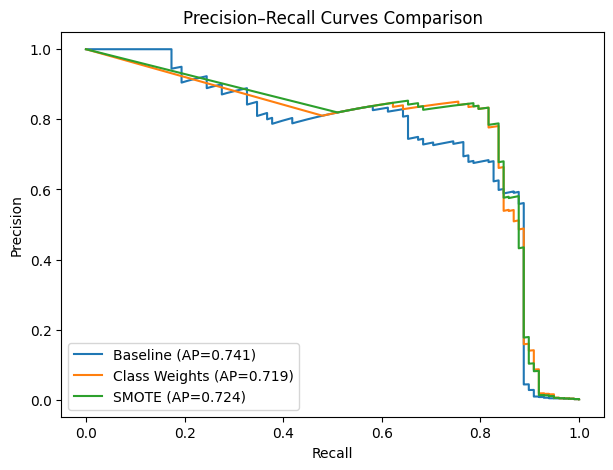

In [10]:
# plot curves for all three changes
def get_pr_curve(model, X, y):
    y_prob = model.predict_proba(X)[:, 1]
    p, r, _ = precision_recall_curve(y, y_prob)
    ap = average_precision_score(y, y_prob)
    return p, r, ap

p0, r0, ap0 = get_pr_curve(baseline_model, X_test_scaled, y_test)
p1, r1, ap1 = get_pr_curve(logreg_weighted, X_test_scaled, y_test)
p2, r2, ap2 = get_pr_curve(logreg_smote, X_test_scaled, y_test)

plt.figure(figsize=(7,5))
plt.plot(r0, p0, label=f"Baseline (AP={ap0:.3f})")
plt.plot(r1, p1, label=f"Class Weights (AP={ap1:.3f})")
plt.plot(r2, p2, label=f"SMOTE (AP={ap2:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves Comparison")
plt.legend()
plt.show()

In [11]:
# save all models
joblib.dump(logreg_weighted, ARTIFACTS_DIR / "logreg_weighted_v1.joblib")
joblib.dump(logreg_smote, ARTIFACTS_DIR / "logreg_smote_v1.joblib")
results_df.to_csv(Path("..") / "reports" / "day6_imbalance_results.csv", index=False)

print("Saved weighted + SMOTE models and results table.")

Saved weighted + SMOTE models and results table.
